In [9]:
import pytorch_lightning as pl
import torch
import whisperx
import gc
import pkg_resources
import pandas as pd
from phonemizer import phonemize
import os
import matplotlib.pyplot as plt


device = "cuda:0" if torch.cuda.is_available() else "cpu"
#torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

#data, sample_rate = 
# 1. Transcribe with original whisper (batched)
#model = whisperx.load_model("large-v2", device, compute_type=compute_type)
#model = whisperx.load_model("medium.en", device)

compute_type = "float16" if torch.cuda.is_available() else "float32"
model = whisperx.load_model("large-v2", device=device, compute_type=compute_type)

audio_folder = "C:/Users/stell/OneDrive/desktop/CANS_LAB/Female_Single_Speakers"
output_folder = "C:/Users/stell/OneDrive/desktop/CANS_LAB/output_timings"




C:\Users\stell\AppData\Local\Temp\ipykernel_8412\1526711077.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


No language specified, language will be first be detected for each audio file (increases inference time).
>>Performing voice activity detection using Pyannote...


C:\Users\stell\miniconda3\envs\eelbrain\Lib\inspect.py:1007: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\stell\miniconda3\envs\eelbrain\Lib\site-packages\whisperx\assets\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.1+cpu. Bad things might happen unless you revert torch to 1.x.


In [ ]:
# Start of creating logits and probability vectors
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)

In [27]:
import os
import string


def process_audio(audio_path):
    
    audio = whisperx.load_audio(audio_path, sr = 16000)
    result = model.transcribe(audio)#, batch_size=batch_size)
    print(result["segments"]) # before alignment

    
    #Load alignment model + align
    align_model, metadata = whisperx.load_align_model(model_name = "jonatasgrosman/wav2vec2-large-xlsr-53-english", device=device, language_code = 'en')
    #align_model, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
    
    # Add word-level timestamps
    result_aligned = whisperx.align(result["segments"], align_model, metadata, audio, device, return_char_alignments=False)
    #result_aligned = whisperx.(phoneme_transcript, align_model, metadata, audio, device)

    return result_aligned
    

# removes any punctuations from string
def remove_punctuation(text):
    # keep apostrophes though
    punc = '''!()-[]{};:",<>./?@#$%^&*_~'''
    for ch in punc:
        text = text.replace(ch, "")
    return text

def get_timings(result_aligned):
    word_data = []
    phoneme_data = []
    # get word-level timings
    # get word-level timings
    for seg in result_aligned["segments"]:
        for word in seg["words"]:
            #remove punctuation and change to all lower case
            no_punc = remove_punctuation(word["word"]).lower()
               
            #print(f"{word['word']}: {word['start']:.4f}s - {word['end']:.4f}s")
          
            word_data.append({
                "Word": no_punc,
                "Start": round(word["start"], 7),
                "End": round(word["end"], 7)
            })
    df_word_whisper = pd.DataFrame(word_data)
    
    return df_word_whisper

    
        


In [28]:
import os


for filename in os.listdir(audio_folder):
    if filename.lower().endswith(('.wav', '.mp3', '.flac')):
        file_path = os.path.join(audio_folder, filename)
        print(f"\nProcessing: {filename}")

        aligned = process_audio(file_path)
        df = get_timings(aligned)

        base_name = os.path.splitext(filename)[0] + "_whisperx"
        csv_path = os.path.join(output_folder, f"{base_name}.csv")
        df.to_csv(csv_path, index=False, float_format="%.7f")
        
        print(f"Saved CSV: {csv_path}")
        

  


Processing: F01_single105.wav
Detected language: en (1.00) in first 30s of audio...
[{'text': ' In the bosom of one of those spacious coves which indent the eastern shore of the Hudson, at that broad expansion of the river, denominated by the ancient Dutch navigators the Tappan Zee, there lies a small market town, or rural port, which by some is called Greensburg, but which is more generally and properly known by the name of Tarrytown. This name was given, we are told, in former days, by the good housewives of the adjacent country,', 'start': 0.031, 'end': 29.545}, {'text': ' from the inveterate propensity of their husbands to linger about the village tavern on market days. Not far from this village, perhaps about two miles, there is a little valley, or rather lap of land, among high hills, which is one of the quietest places in the whole world. From the listless repose of the place, and the peculiar character of its inhabitants, who are descendants from the original Dutch settlers, t

In [60]:
import os

original_timings = "C:/Users/stell/OneDrive/desktop/CANS_LAB/original_timings"

for filename in os.listdir(original_timings):
    if filename.lower().endswith('.csv'):

        base_name = os.path.splitext(filename)[0] 
        
        file_path = os.path.join(original_timings, filename)
        df_OG = pd.read_csv(file_path)
        
        # Select rows with just words
        words_OG_df = df_OG[df_OG["tier"] == "words"]
        # To select the current relevant columns -  word; start;end
        df_OG_selected = words_OG_df[["text", "tier", "tmin", "tmax"]]

        # Reset index
        df_OG_selected.reset_index(drop=True, inplace=True)

        whisper_path = os.path.join(output_folder, f"{base_name}_whisperx.csv")
       
        df_whisper = pd.read_csv(whisper_path).reset_index(drop=True)
        
        #base_name = os.path.splitext(filename)[0]  + "_whisperx"  
        combined_dir  = r"C:/Users/stell/OneDrive/desktop/CANS_LAB/compare_timings"
        os.makedirs(combined_dir, exist_ok=True)  # Make sure the directory exists

        combined_timings = pd.concat([df_OG_selected, df_whisper], axis=1)
        out_path = os.path.join(combined_dir, f"{base_name}_combined.csv")
        combined_timings.to_csv(out_path, index=False, float_format="%.7f")

        if os.path.exists(out_path):
            os.remove(out_path)
    
        combined_timings.to_csv(out_path, index=False, float_format="%.7f")

    combined_df = pd.read_csv(out_path)
    
    # Detect word misalignments
    combined_df["word_prev"] = combined_df["Word"].shift(1)
    combined_df["start_prev"] = combined_df["Start"].shift(1)
    combined_df["end_prev"] = combined_df["End"].shift(1)

    fixed = fix_errors(combined_df)
    fixed.to_csv(out_path, index=False)

    mismatched_rows = fixed[fixed["text"] != fixed["Word"]]
    print("File name:", base_name)
    # print(mismatched_rows)
    print(f"Remaining mismatches: {len(mismatched_rows)}")
    print("\n")

    # Drop mismatched rows from the fixed DataFrame
    lala = fixed[fixed["text"] == fixed["Word"]]
    #print(lala)

File name: F01_single105
Remaining mismatches: 3


File name: F03_single105
Remaining mismatches: 3


File name: F05_single105
Remaining mismatches: 2


File name: F07_single105
Remaining mismatches: 3


File name: F11_single105
Remaining mismatches: 40


File name: F12_single105
Remaining mismatches: 146


File name: F15_single105
Remaining mismatches: 94


File name: F16_single105
Remaining mismatches: 91


File name: F19_single105
Remaining mismatches: 26


File name: F21_single105
Remaining mismatches: 3


File name: F22_single105
Remaining mismatches: 3


File name: F23_single105
Remaining mismatches: 43




F01_single105_combined.csv
F03_single105_combined.csv
F05_single105_combined.csv
F07_single105_combined.csv
F11_single105_combined.csv
F12_single105_combined.csv
F15_single105_combined.csv
F16_single105_combined.csv
F19_single105_combined.csv
F21_single105_combined.csv
F22_single105_combined.csv
F23_single105_combined.csv


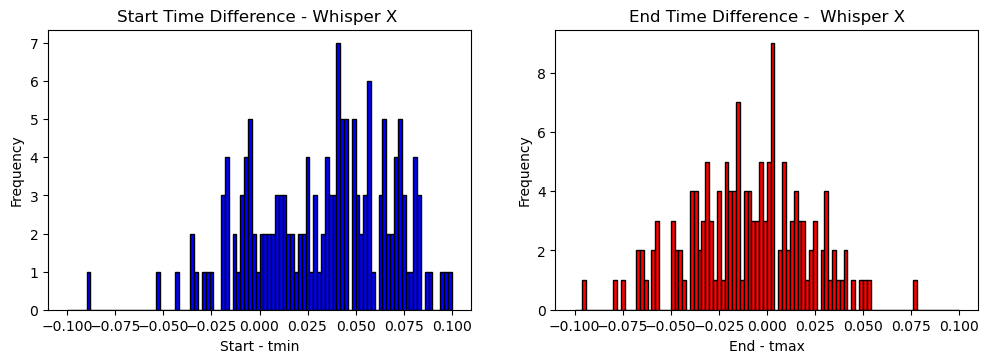

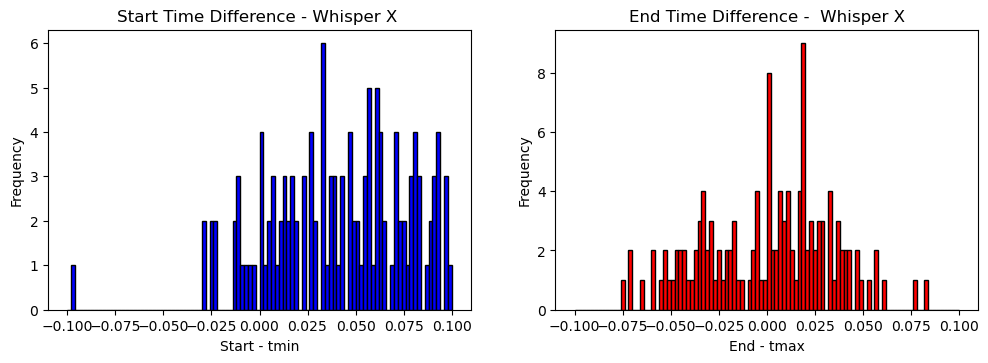

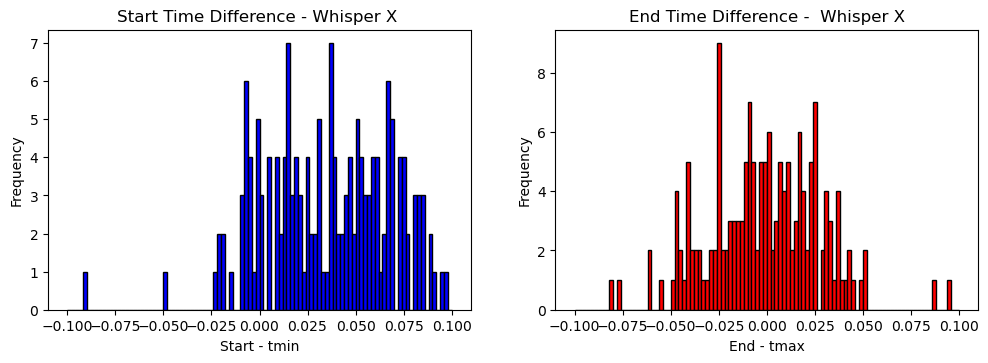

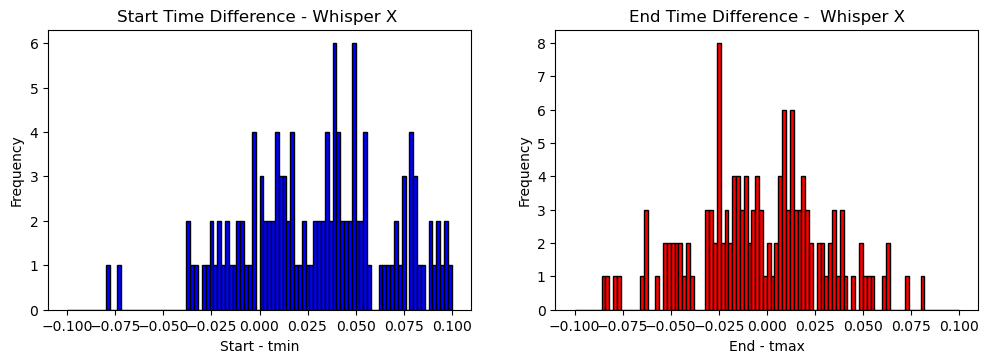

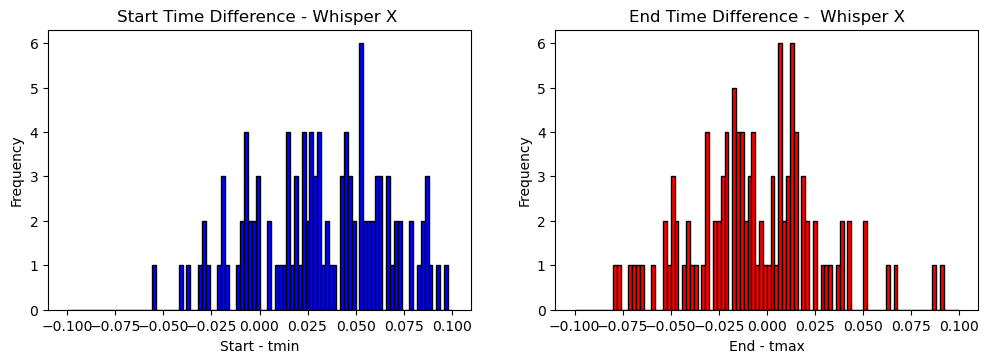

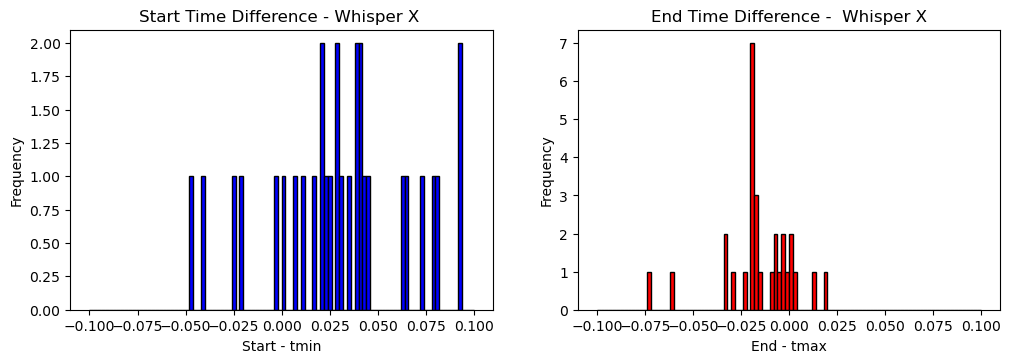

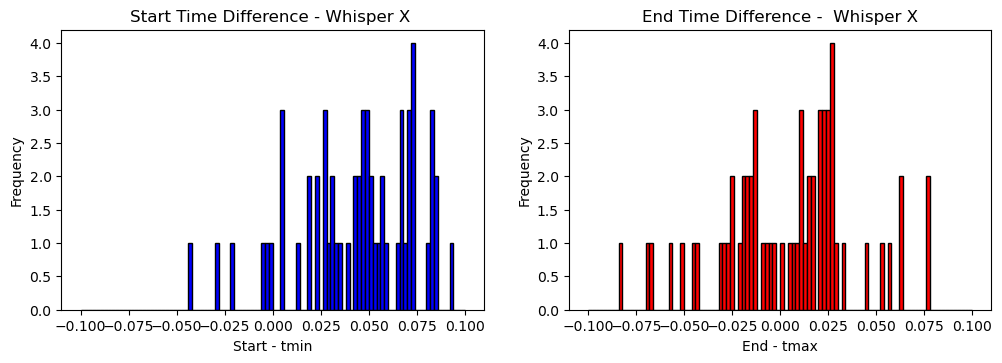

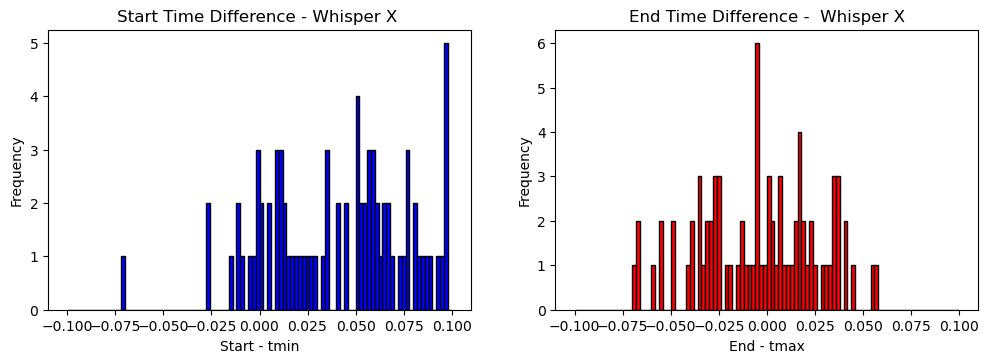

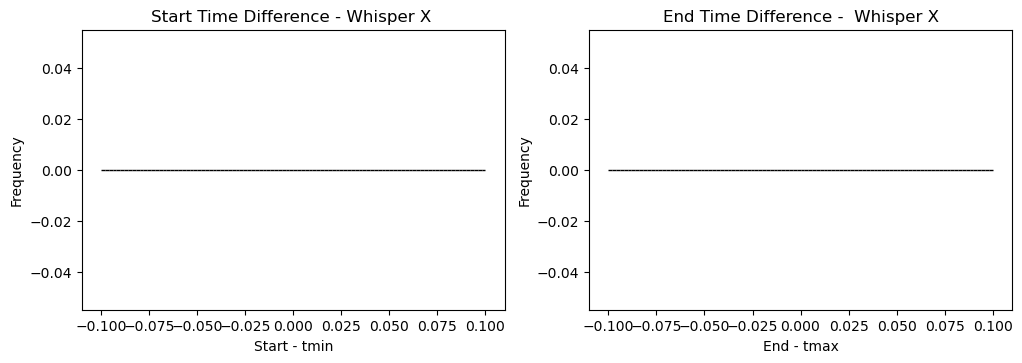

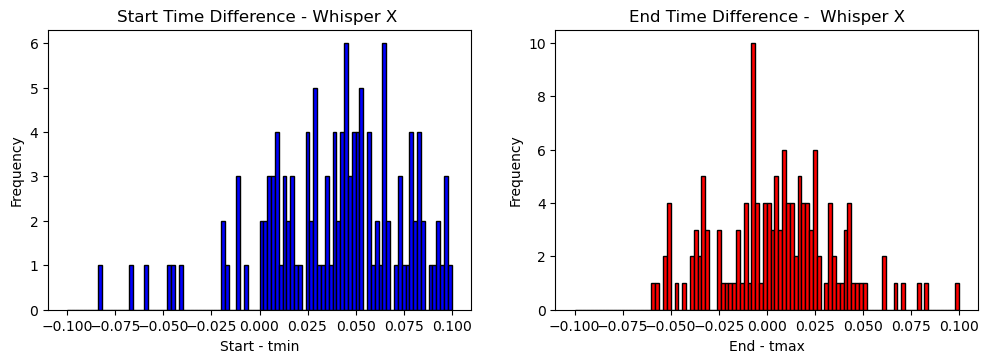

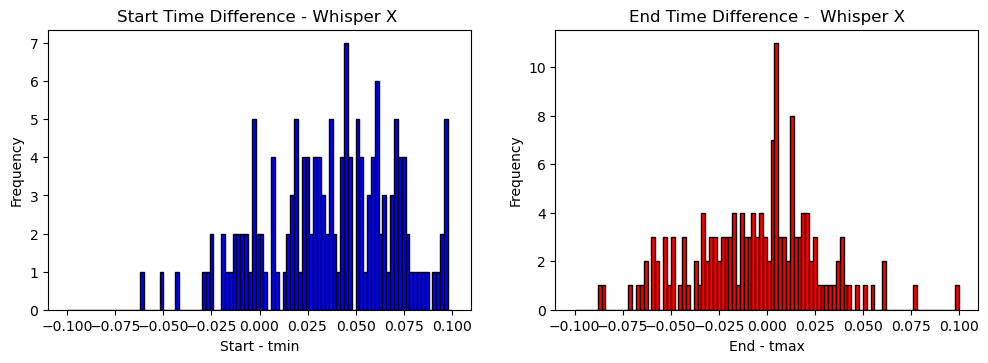

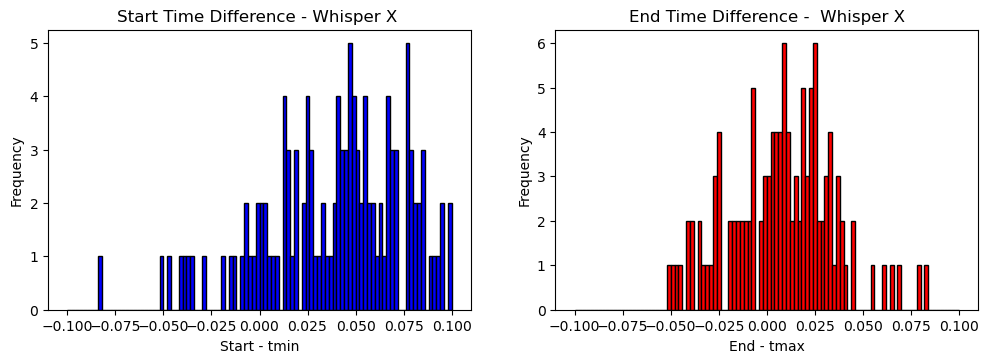

In [54]:
compare_timings = "C:/Users/stell/OneDrive/desktop/CANS_LAB/compare_timings"
comparison = os.listdir(compare_timings)
# for filename in comparison[:3]: #only looking at the first 3
#     print(filename)
#     get_difference(filename)

for filename in comparison:
    print(filename)
    full_path = os.path.join(compare_timings, filename)
    df = pd.read_csv(full_path)
    # Utilize only rows where words match
    df_matched = df[df["text"] == df["Word"]].copy()
    get_difference(df_matched)


In [26]:
import pandas as pd
import matplotlib.pyplot as plt


def fix_errors(combined_df):
    
    # When there are misalignments (this is for only one specific case when whisper merges two words)
    for idx, row in combined_df.iterrows():
        if row["text"] != row["Word"]:
            
            combined_df.at[idx, "Start"] = row["start_prev"]
            combined_df.at[idx, "End"] = row["end_prev"]
            
            if row["text"] == row["word_prev"]:
                combined_df.at[idx, "Word"] = row["word_prev"]
            
    #Delete the other columns when done with them      
    combined_df = combined_df.drop(columns=["word_prev", "start_prev", "end_prev"])
    
    # In case the start timings do not begin at 0
    offset = combined_df["Start"].iloc[0]
    
    # Shift all Start and End times to make the first word start at 0
    combined_df["Start"] = combined_df["Start"] - offset
    combined_df["End"] = combined_df["End"] - offset


    # For now, make them into a csv file
    combined_df.to_csv('compare_timings.csv', index = False)
    
    return combined_df

In [47]:
def get_difference(combined_df):
    #Get the differences
    
    combined_df_start =  combined_df["Start"] - combined_df["tmin"]
    #print("start difference\n",combined_df_start)
    
    combined_df_end =  combined_df["tmax"] - combined_df["End"]
    #print("End difference\n", combined_df_end)
    
    duration_OG = combined_df["tmax"] - combined_df["tmin"]
    #print("duration OG\n", duration_OG)
    duration_whisper = combined_df["End"] - combined_df["Start"]
    #print("duration whisper\n", duration_whisper)

    plt.figure(figsize=(12, 8))
    
    # Histogram of Start difference
    plt.subplot(2, 2, 1)
    plt.hist(combined_df["Start"] - combined_df["tmin"], bins = 100, color='blue', edgecolor='black', range=(-0.1, 0.1))
    plt.title("Start Time Difference - Whisper X ")
    plt.xlabel("Start - tmin")
    plt.ylabel("Frequency")
    
    # Histogram of End difference
    plt.subplot(2, 2, 2)
    plt.hist(combined_df["End"] - combined_df["tmax"], bins = 100, color='red', edgecolor='black', range=(-0.1, 0.1))
    plt.title("End Time Difference -  Whisper X")
    plt.xlabel("End - tmax")
    plt.ylabel("Frequency")

    return plt.show